# Sprint 2

In this sprint we used clustering, classification and regression on the tripadvisor dataset. Before we start implementing those ideas we do some preprocessing and feature extraction.

## Resizing our image dataset

We will do this once (in parallel) and then save them so the next time we load our images it doesn't take too long. This resize keeps the aspect ratio.

In [2]:
import os
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm
from fastai.vision.all import *
import matplotlib.pyplot as plt

original_path = Path('tripadvisor_dataset/tripadvisor_images')
trns_path = Path('tripadvisor_dataset/tripadvisor_images_small')
trns_path.mkdir(exist_ok=True)

# max_workers = amount of cores

original_df = pd.read_csv("./tripadvisor_dataset/restaurant_listings.csv")

if os.listdir(trns_path)==[]:
    resize_images(original_path, max_workers=4, dest=trns_path, max_size=256)

## Creating our dataset of images

Let's look at some images

((256, 192), (256, 256))

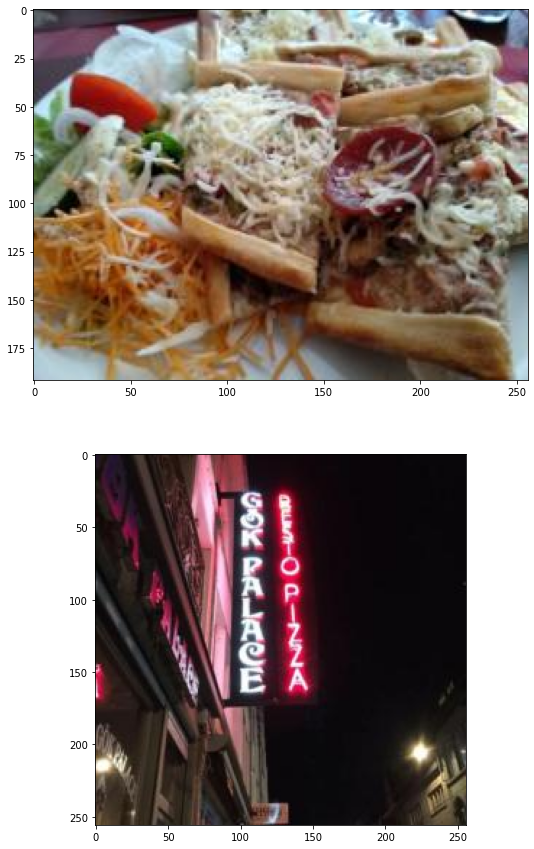

In [3]:
img_folder = "./tripadvisor_dataset/tripadvisor_images_small"
image_files=os.listdir(img_folder)
fig=plt.figure(figsize=(10,15))
plt.subplot(2,1,1)
img1=PILImage.create(os.path.join(img_folder,image_files[0]))
plt.imshow(img1)
plt.subplot(2,1,2)
img2=PILImage.create(os.path.join(img_folder,image_files[1]))
plt.imshow(img2)
img1.size,img2.size

We can already see that our images have different sizes and not all of our pictures are pictures of food. So let's resize them to 128x128.

In [4]:
# Resizing to this sizes
IMG_HEIGHT = 128
IMG_WIDTH = 128

def create_dataset(img_folder, n=None):
    # n = amount of images
    image_files=os.listdir(os.path.join(img_folder))
    if n==None:
        n=len(image_files)
    images = np.zeros((n, IMG_HEIGHT* IMG_WIDTH* 3))
    for i,file in enumerate(image_files[:n]):
        # print(f"{i},{file}")
        img=PILImage.create(os.path.join(img_folder,file))
        img_resized=img.resize((IMG_HEIGHT,IMG_WIDTH))
        img_np=np.array(img_resized).flatten()
        images[i]=img_np/255
    return images

images = create_dataset(img_folder)

Lets look at some of our cropped images

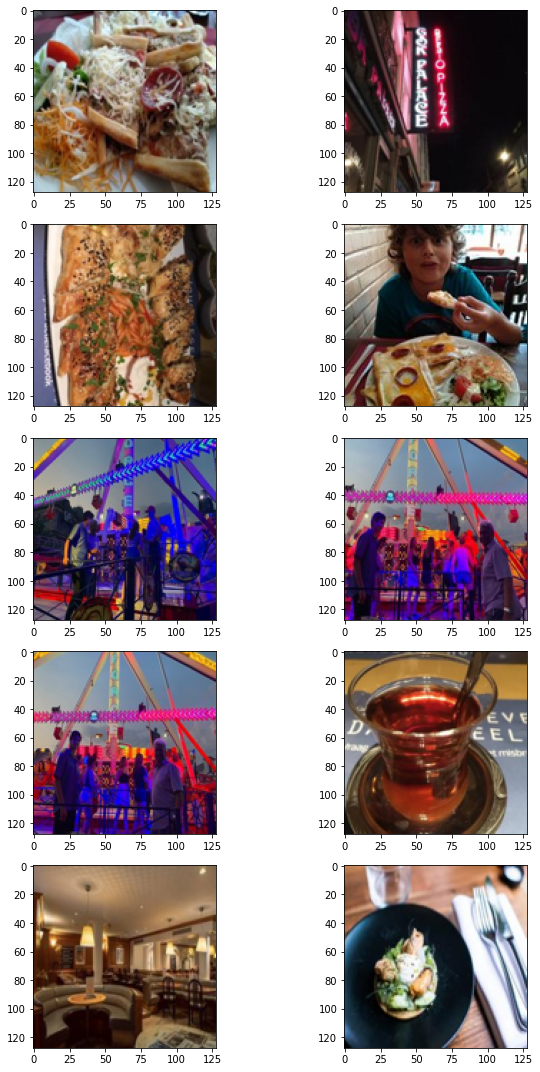

In [5]:
fig=plt.figure(figsize=(10,15))
for i in range(0,10):
    plt.subplot(5,2,i+1)
    plt.imshow(images[i].reshape(IMG_HEIGHT,IMG_WIDTH,3))
fig.tight_layout()
plt.show()

Not all of these images are usefull, we will have to find a way to clean our dataset because we know: garbage in is garbage out. For our ideas we need specifically images of food, images that contain buildings etc needs to be filtered out.

We will first start with feature extraction followed by an initial clustering to find a way to separate the food images from the non food images.

## Feature extraction - part 1
We will first start with the basic HOG algorithm that we have seen in our lab.

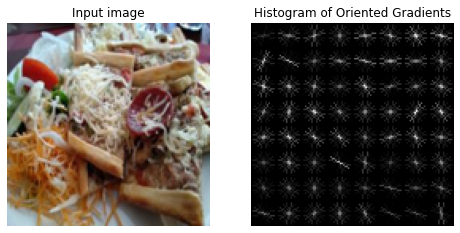

In [6]:
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt

img = images[0].reshape(IMG_HEIGHT,IMG_WIDTH,3)

fd, hog_image = hog(img,orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, channel_axis=-1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(img, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

This is what we get from 1 picture, now let's apply it to our whole dataset

In [7]:
images_hogs = np.zeros((images.shape[0], 512 * 3))

for i, img in tqdm(enumerate(images), total=len(images)):
    img = img.reshape((128,128,3))
    for channel in range(3):
        fd = hog(img[:,:,channel], orientations=8, pixels_per_cell=(16, 16),
                cells_per_block=(1, 1), visualize=False, feature_vector=True)
        images_hogs[i, channel*512:channel*512+512] = fd


100%|██████████| 15182/15182 [05:57<00:00, 42.47it/s]


In [8]:
images_hogs.shape

(15182, 1536)

## Clustering
We start with standardizing our data

In [9]:
from sklearn.preprocessing import StandardScaler
# scale hog features
sc = StandardScaler()
hogs_scaled = sc.fit_transform(images_hogs)

Before we start with dimensionality reduction, we will make an initial clustering to get to know our data better and see if it's easy to separate the food images from the non food images.

In [10]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0)
predictions = kmeans.fit_predict(hogs_scaled)

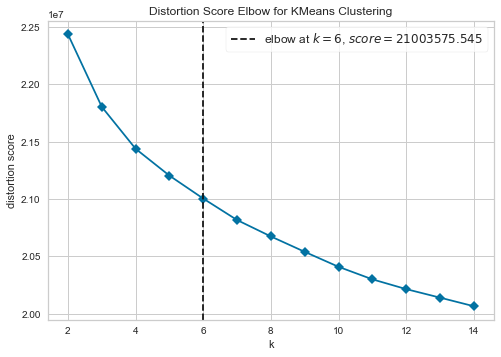

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [39]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()

visualiser = KElbowVisualizer(model, k=(2,15), timings=False)

visualiser.fit(hogs_scaled)
visualiser.show()

Not really a good sign, it doesn't have the distict elbow shape, maybe it's because of our feature extraction. We try it again without the hogs but on our raw pixel data

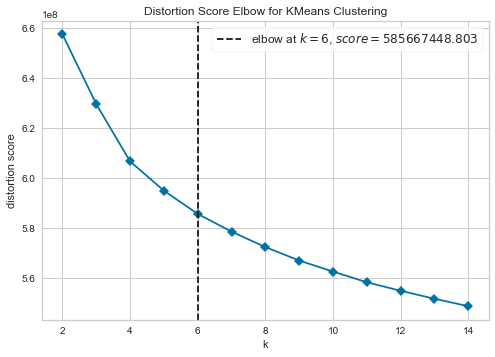

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [40]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()

visualiser = KElbowVisualizer(model, k=(2,15), timings=False)

visualiser.fit(StandardScaler().fit_transform(images))
visualiser.show()

Still the same result sadly, let's see what's in the clusters.

CLUSTER 0


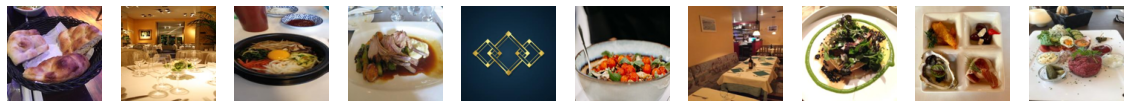

CLUSTER 1


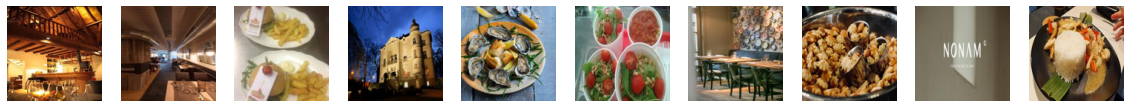

In [13]:
# you can optionally give this function the distances of the instances to the cluster centers (obtainable by using the models transform function)
def show_predictions(predictions, n_clusters, images, distances=None):
    for cluster in range(n_clusters):
        print(f"CLUSTER {cluster}")

        cluster_images = images[np.where(predictions == cluster)]

        if distances is not None:
            # we sort the images so that they are displayed in order of distance to cluster center
            cluster_distances=  np.min(distances[np.where(predictions == cluster)], axis=1)
            cluster_instances_sorted = np.argsort(cluster_distances)
            cluster_images = cluster_images[cluster_instances_sorted[::-1]]
                
        num_pics = 10 if cluster_images.shape[0] > 10 else cluster_images.shape[0]

        # try to pick out images closes to the cluster centers
        if num_pics == 0:
            print("No images in this cluster")
            continue
        if num_pics == 1:
            plt.figure()
            plt.imshow(cluster_images[0].reshape((128,128,3)))
            plt.axis("off")
            plt.show()
            continue
        indices = np.random.choice(np.arange(cluster_images.shape[0]), num_pics, replace=False)
        _, axs = plt.subplots(1, num_pics, figsize=(20,20))
        axs = axs.flatten()
        for img, ax in zip(cluster_images[indices], axs):
            ax.imshow(img.reshape((128,128,3)))
            ax.set_axis_off()
        plt.show()

show_predictions(predictions, 2, images)

The result after clustering on the HOG images is not desirable. The histogram of gradients maybe isn't the best way to cluster dishes. In the next step we will try out other feature extraction techniques and compare them by visual result and on the silhouette score and plot.

We can also see there there are copies of the same image, it's best to also remove them.

## Feature extraction - part 2

We'll try an alternative to HOG, namely SIFT and SURF. 

### SURF
Speeded up robust features (SURF) is a patented local feature detector and descriptor. It can be used for tasks such as object recognition, image registration, classification, or 3D reconstruction. It is partly inspired by the scale-invariant feature transform (SIFT) descriptor. The strength of the SURF algorithm uses box filters as seen below. This enables object recognition and tracking possibilities. However this algorithm is pattented and not availaible in the ```opencv-contribute``` module that we used. So we decided to switch to SIFT.


Image


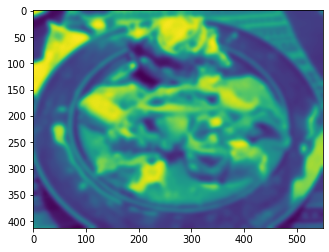

No of  points: 316


(316, 70)

In [14]:
import mahotas
import mahotas.demos
import mahotas as mh
import numpy as np
from pylab import imshow, show
from mahotas.features import surf
import cv2
 
# loading image
image = cv2.imread(r'tripadvisor_dataset/tripadvisor_images/694642_0.jpg', cv2.COLOR_BGR2RGB)[..., ::-1]

nuclear = image[:, :, 0]
 
# adding gaussian filter, we choose 4 as sigma value as test
nuclear = mahotas.gaussian_filter(nuclear, 4)
 
# showing image
print("Image")
# imshow(image)
imshow(nuclear)

show()
 
 
# getting Speeded-Up Robust Features
spoints = surf.surf(nuclear)
print("No of  points: {}".format(len(spoints)))
spoints.shape

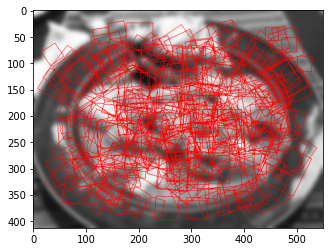

In [15]:
f2 = surf.show_surf(nuclear, spoints)
imshow(f2)

### SIFT (Scale-Invariant Featue Transform)
SIFT is a computer vision algorithm that detects and describes local features in images. The result of the SIFT features is that the detection is invariant to scale and rotation. This can be handy because we can see that the dishes are twisted and turned in all possible directions.

The algorithm proceeds as follows:

    1) Scale-space peak selection: Potential location for finding features
    2) Keypoint Localization: Accurately locating the feature keypoints
    3) Orientation Assignment: Assigning orientation to keypoints
    4) Keypoint descriptor: Describing the keypoints as a high dimensional vector
    5) Keypoint Matching
  
source: https://medium.com/@deepanshut041/introduction-to-sift-scale-invariant-feature-transform-65d7f3a72d40

Number of Keypoints Detected In The Training Image:  142
Number of Keypoints Detected In The Query Image:  142


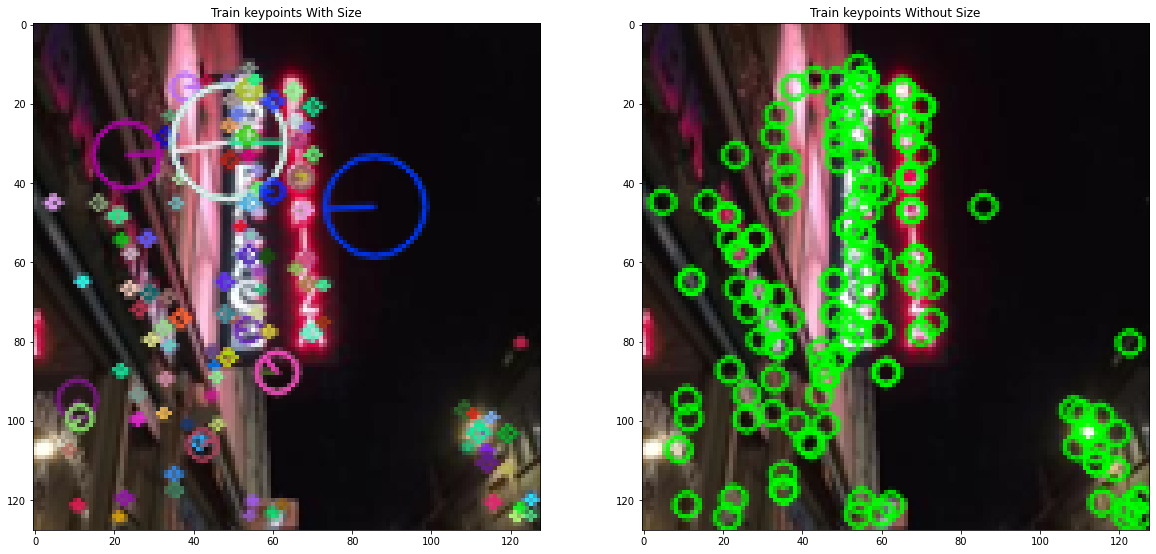

In [16]:
import cv2
sift = cv2.xfeatures2d.SIFT_create()

img = images[1].reshape(IMG_HEIGHT,IMG_WIDTH,3)

# SIFT function only accepts images with 8 bit integer values
image8bit = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

# Convert the training image to gray scale
training_gray = cv2.cvtColor(image8bit, cv2.COLOR_RGB2GRAY)


train_keypoints, train_descriptor = sift.detectAndCompute(training_gray, None)
test_keypoints, test_descriptor = sift.detectAndCompute(training_gray, None)

keypoints_without_size = np.copy(image8bit)
keypoints_with_size = np.copy(image8bit)

cv2.drawKeypoints(image8bit, train_keypoints, keypoints_without_size, color = (0, 255, 0))
cv2.drawKeypoints(image8bit, train_keypoints, keypoints_with_size, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display image with and without keypoints size
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("Train keypoints With Size")
plots[0].imshow(keypoints_with_size, cmap='gray')

plots[1].set_title("Train keypoints Without Size")
plots[1].imshow(keypoints_without_size, cmap='gray')

# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Training Image: ", len(train_keypoints))

# Print the number of keypoints detected in the query image
print("Number of Keypoints Detected In The Query Image: ", len(test_keypoints))

In the pictures you can see examples of keypoints of the keypoint descriptor of SIFT. Keypoints between two different images can be matched by identifying their nearest neighbours.

For the matching of the pictures we will apply kmeans on the descriptors to create visual words. 

First we extract the keypoints and descriptors from every image

In [17]:
def sift_features(images):
    sift_vectors = {}
    descriptor_list = []
    features = []
    sift = cv2.xfeatures2d.SIFT_create()
    for img in images:
        img = img.reshape(IMG_HEIGHT,IMG_WIDTH,3)
        # SIFT function only accepts images with 8 bit integer values
        image8bit = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

        # Convert the training image to gray scale
        training_gray = cv2.cvtColor(image8bit, cv2.COLOR_RGB2GRAY)


        keypoints, descriptor = sift.detectAndCompute(training_gray, None)
        if descriptor is not None:
            descriptor_list.extend(descriptor)
            features.append(keypoints)

    return (descriptor_list, np.array(features))


descriptors, features = sift_features(images)


C:\Users\hikma\AppData\Local\Temp\ipykernel_19120\3566675265.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return (descriptor_list, np.array(features))


In [18]:
descriptors[0].shape # descriptors is a list

(128,)

We now have an array with a huge number of descriptors. We cannot use all of them to create the model, so we need to cluster them. A rule-of-thumb is to create k centers with k = number of categories * 10. We choose 7 as number_of_categories, then we end up 70 features for each image. 

In [19]:
from sklearn.cluster import KMeans

number_of_categories = 7

def kmeans(descriptor_list):
    k = number_of_categories * 10
    kmeans = KMeans(n_clusters = k, n_init=10)
    kmeans.fit(descriptor_list)
    visual_words = kmeans.cluster_centers_ 
    return visual_words

# visual_words = kmeans(descriptors)
# visual_words

visual_words = np.loadtxt("visual_words.txt")

In [20]:
# np.savetxt("visual_words.txt", visual_words)
# np.loadtxt("visual_words.txt")

### Making histograms


In [21]:
# Find the index of the closest central point to the each sift descriptor. 
# Takes 2 parameters the first one is a sift descriptor and the second one is the array of central points in k means
# Returns the index of the closest central point.  
from scipy.spatial import distance

def find_index(image, center):
    count = 0
    ind = 0
    for i in range(len(center)):
        if(i == 0):
           count = distance.euclidean(image, center[i]) 
           #count = L1_dist(image, center[i])
        else:
            dist = distance.euclidean(image, center[i]) 
            #dist = L1_dist(image, center[i])
            if(dist < count):
                ind = i
                count = dist
    return ind

In [22]:
def image_class(features, centers, descriptors):
    begin = 0
    histogrammen = []
    for f in features:
        histogram = np.zeros(len(centers))
        for i in range(begin, begin + len(f)):
            ind = find_index(descriptors[i], centers)
            histogram[ind] += 1
        histogrammen.append(histogram)
        begin += len(f)

    return histogrammen


# image_features = image_class(features, visual_words, descriptors)

image_features = np.loadtxt("image_features.txt")

In [23]:
# np.savetxt("image_features.txt", image_features)
# np.loadtxt("image_features.txt")

In [24]:
print(len(image_features)) # amount of images
image_features[0].shape # amount of centroids

15175


(70,)

Now we really cluster the image based on the histograms. First we will try default clustering.

In [25]:
kmeans = KMeans(2)
sift_predictions = kmeans.fit_predict(image_features)

CLUSTER 0


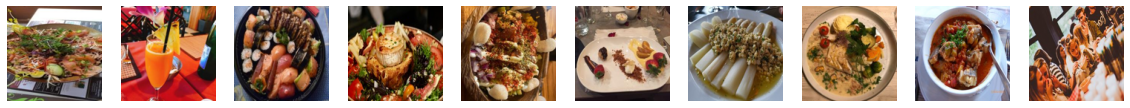

CLUSTER 1


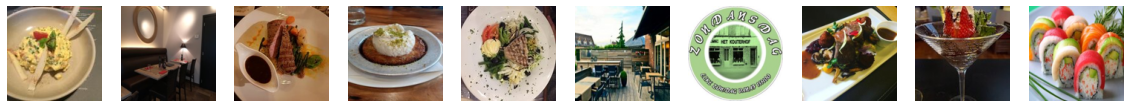

In [26]:
show_predictions(sift_predictions, 2, images)

From these experiments we concluded that we don't have a good way to measure the performance of our clusterng, It's difficult for us to look at the images of each cluster too see if our model did a good job. If we don't have a way to evaluate the performance of the model we don't know which cluster method or feature extraction would be better. To solve this we perform the same methods on a similar labelled dataset of food and buildings that we obtained from kaggle.

At first glance it looks like the clusters are random. Splitting the dataset in food and others might not be as easy as using two clusters and keeping one. We'll try to use more clusters and hope the food clusters doesn't contain many irrelevant images such as buildings. Just using two clusters and seperating food and others is not going to work.

The search of an optimal cluster algorithm will continue in [differentiating-buildings-from-food.ipynb](./differentiating-buildings-from-food.ipynb) and we will now use the best cluster algorithm that was concluded from the other notebook.

## Idea 1: Recommendation system

The idea is that a model will return restaurants correlated with the input. The model will cluster all the images of the restaurants. As input a user gives an image (for example a picture of pasta) and see in which cluster it ends up. All the restaurants from the images in that cluster will be recommended to the user.

This is the image we'll use as input for our model

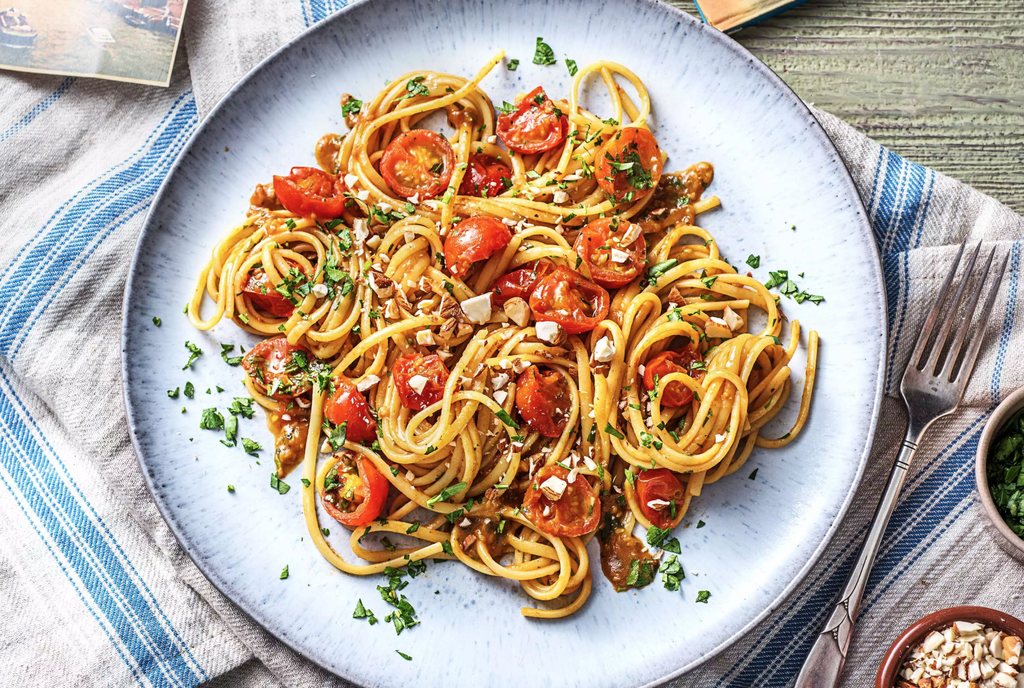

In [27]:
img = PILImage.create('pasta.png')
img

In [28]:
img_resized = img.resize((IMG_HEIGHT,IMG_WIDTH))
img_resized = np.array(img_resized)
img_resized.shape


(128, 128, 3)

Now we will use the HOG algorithm to extract the features of the image.

In [29]:
input_hogs = np.zeros((1, 512 * 3))

img = img_resized.reshape((128,128,3))
for channel in range(3):
    fd = hog(img[:,:,channel], orientations=8, pixels_per_cell=(16, 16),
            cells_per_block=(1, 1), visualize=False, feature_vector=True)
    input_hogs[0, channel*512:channel*512+512] = fd

input_hogs_scaled = sc.transform(input_hogs)

We cluster the image features again, but this time not in two because now we want to differentiate meals. If we use a small number of clusters, the recommended list will be huge and will probably contain many images not very related to our input image (high recall). If we use a high number of clusters we'll most likely have a small cluster with few restaurants that are hopefully very similar to our input image (high precision). As a recommendation system a high precision is preferred.

In [30]:
from sklearn.cluster import Birch
birch = Birch(n_clusters=100)
predictions = birch.fit_predict(hogs_scaled)
predictions

array([91,  8, 19, ..., 16, 74, 43], dtype=int64)

We check if everything looks normal in our clusters (checking if there is a cluster with almost all elements, but that's not the case)

In [31]:
unique, counts = np.unique(predictions, return_counts=True)

print(np.asarray((unique, counts)).T)

[[  0 115]
 [  1  33]
 [  2  94]
 [  3 256]
 [  4  15]
 [  5 238]
 [  6  74]
 [  7 458]
 [  8 181]
 [  9 392]
 [ 10  98]
 [ 11 104]
 [ 12 124]
 [ 13 228]
 [ 14 395]
 [ 15  79]
 [ 16 464]
 [ 17 186]
 [ 18 130]
 [ 19 166]
 [ 20  80]
 [ 21 593]
 [ 22 163]
 [ 23  34]
 [ 24 174]
 [ 25 172]
 [ 26  38]
 [ 27 210]
 [ 28 124]
 [ 29  95]
 [ 30  19]
 [ 31 112]
 [ 32 163]
 [ 33 176]
 [ 34 224]
 [ 35 136]
 [ 36 236]
 [ 37 190]
 [ 38 228]
 [ 39 116]
 [ 40 311]
 [ 41 387]
 [ 42 177]
 [ 43 138]
 [ 44 497]
 [ 45 149]
 [ 46  31]
 [ 47 166]
 [ 48 106]
 [ 49 202]
 [ 50 256]
 [ 51 160]
 [ 52 140]
 [ 53 105]
 [ 54  94]
 [ 55 500]
 [ 56 124]
 [ 57  39]
 [ 58  64]
 [ 59 304]
 [ 60 181]
 [ 61 199]
 [ 62  66]
 [ 63 161]
 [ 64  58]
 [ 65 164]
 [ 66 101]
 [ 67  84]
 [ 68  53]
 [ 69  91]
 [ 70  94]
 [ 71 242]
 [ 72  47]
 [ 73  82]
 [ 74  95]
 [ 75  41]
 [ 76  96]
 [ 77  35]
 [ 78  54]
 [ 79  61]
 [ 80  71]
 [ 81  32]
 [ 82  69]
 [ 83 148]
 [ 84  39]
 [ 85  45]
 [ 86  36]
 [ 87  12]
 [ 88  21]
 [ 89  55]
 [ 90 145]

Predict in which cluster the image belongs. 

In [32]:
cluster = birch.predict(input_hogs_scaled)
cluster

array([48], dtype=int64)

In [33]:
indices = np.where(predictions == cluster)[0]
print(len(indices))
file_names = [image_files[i] for i in list(indices)]
unique_restaurants = set()
for file in file_names:
    unique_restaurants.add(int(file.split("_")[0]))
unique_restaurants

106


{740594,
 740639,
 740664,
 740774,
 796834,
 814602,
 850234,
 1025415,
 1054072,
 1056371,
 1070849,
 1199541,
 1223250,
 1307816,
 1495275,
 1913510,
 2179900,
 2493102,
 2599711,
 3246304,
 3253521,
 3265769,
 3605165,
 3651739,
 3669846,
 3671568,
 3676410,
 3800252,
 3806497,
 4047780,
 4088197,
 4227710,
 4260910,
 4942498,
 5521565,
 5608772,
 6207281,
 6704558,
 6773411,
 6912418,
 6920678,
 6957717,
 7047337,
 7141012,
 7159789,
 7215510,
 7243474,
 7261390,
 7285489,
 7332647,
 7991016,
 8514677,
 8552211,
 8594246,
 8674461,
 8828302,
 10025700,
 10251754,
 10429129,
 10643138,
 10947847,
 11533809,
 11576275,
 11806847,
 12132297,
 12231868,
 12272003,
 12406258,
 12872036,
 12884041,
 12936693,
 13473197,
 13504665,
 13558601,
 13964498,
 15007602,
 15039251,
 15092124,
 15319535,
 15811969,
 16882674,
 17146516,
 17381180,
 18542716,
 18915522,
 19866111,
 20938371,
 21256157,
 21288367,
 21312286,
 23444367,
 23696876,
 24036802}

These are the restaurants that have at least 1 image in the same cluster as our input image

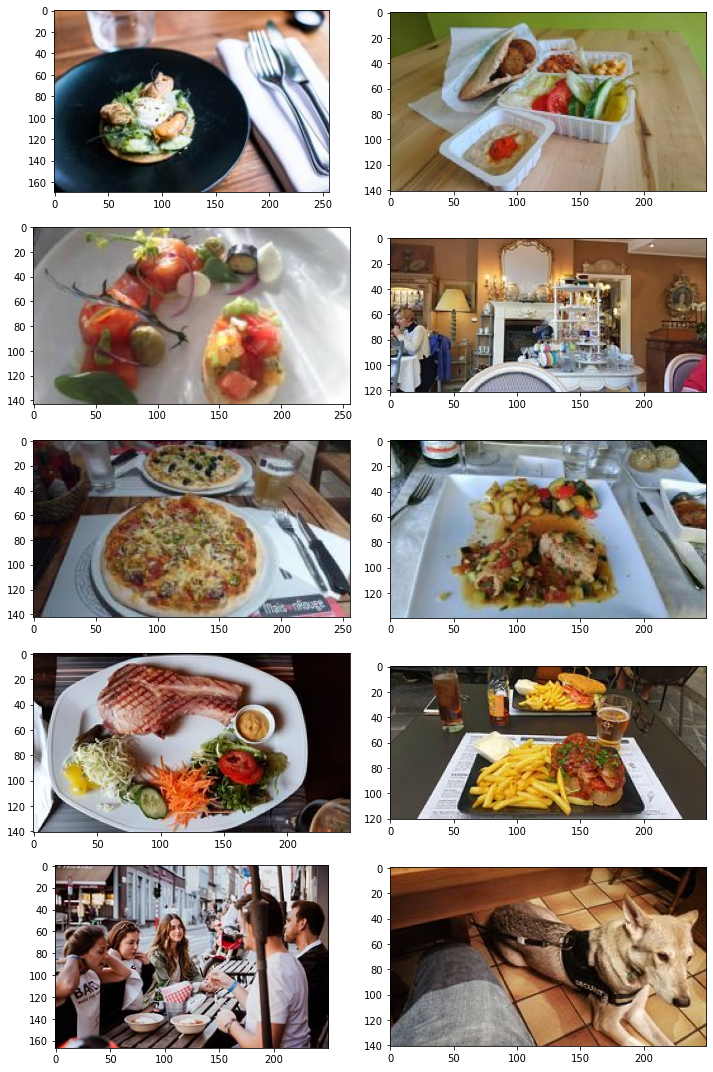

In [38]:
fig=plt.figure(figsize=(10,15))
for i in range(0,10):
    plt.subplot(5,2,i+1)
    img = PILImage.create(img_folder + '/' + file_names[i])
    # restaurant name get be obtained in file_names[i]
    plt.imshow(img)
fig.tight_layout()
plt.show()



Now we get the restaurant names from the restaurant ids. These are the recommended restaurants from our input image.

In [35]:
related_restaurants = original_df[original_df.id.isin(unique_restaurants)]
related_restaurants["restaurant name"]

48                 De Ceder
49          't Galgenhuisje
53                  Kokarde
59               Meme Gusta
61        Sushi Palace Gent
               ...         
2204        't Stationneken
2270             Torenhuyze
2285           Lunch Garden
2316           OUDENBERGHOF
2354    De graaf van egmont
Name: restaurant name, Length: 93, dtype: object

The output of this recommendation system can be a list of restaurants or the images with the corresponding restaurant name depending on what a user prefers.

### Conclusion: 

(explanation is based on the image below)


The results are not good, but also not very bad. We can clearly see some similarity with the input picture (for example the same point of view, the plate). We have tried a very small number of clusters (2-10) and very large amount of clusters (100-10000). We will try to use deep learning on this preoblem to see if we will get better results in sprint 3.

![image](./hog_output.png)


We've tried to do the same recommendation system but with SIFT to see if our conclusion from [differentiating-buildings-from-food.ipynb](./differentiating-buildings-from-food.ipynb) was correct. It was clearly correct our conclusion🥳, we deleted it from the notebook now but the results of SIFT looked very random. With HOG we can see correlation with the input image. In the following picture you can see the output when we used SIFT.

![image](./sift_output.png)

## Idea 2: budget filter


Now that the customers are able to find recommended restaurants based on the image of the food that they are interested in, it would be beneficial to also include a possibility to filter the price based on the given budget that the consumer is willing to spend.

However the price range feature is not a good feature (see our analysis from sprint 1, cheap drinks are somtimes included for lower price and IGent had an upper price of €200 😵). In the notebook https://www.kaggle.com/code/ramantalwar00/classsification-restaurant-price-final we will research a posibility to classify the restaurants into 3 categories based on the price_tag feature.
</br><span style="color:red">please make sure to view the latest version of the kaggle notebook</span>

This classifier is not only important for the customer but can also be highly informative for the different restaurant owners. The restaurant owner can detect after the training process of the classification what features affect the price range the most. He / she / they could then opt to change some values to get over the edge of the class into another class. 

The restaurant owner could then use this knowledge to get more insights in his business, adapt his price range to his restaurant area, get a step ahead from his competitors (for example looking which restaurant features are relatively easy to incorporate and will get him into a high price range),...

## Idea 3: influence on reviews

A final trump card for the restaurant owner would be a possibility to check what affects the number of reviews that you are getting. With a regression model the number of reviews could be predicted. This could also be beneficial for people that want to start a new restaurant and get some insights in what options could spike up these reviews. In the notebook [sprint2_regression_final.ipynb](./sprint2_regression_final.ipynb) this thought will further be explored and examined. 